<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_01_05_value_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Training Start!
EP 010 | Return 22.0 | Epsilon 0.951
EP 020 | Return 16.0 | Epsilon 0.905
EP 030 | Return 32.0 | Epsilon 0.860
EP 040 | Return 16.0 | Epsilon 0.818
EP 050 | Return 27.0 | Epsilon 0.778
EP 060 | Return 42.0 | Epsilon 0.740
EP 070 | Return 44.0 | Epsilon 0.704
EP 080 | Return 41.0 | Epsilon 0.670
EP 090 | Return 35.0 | Epsilon 0.637
EP 100 | Return 62.0 | Epsilon 0.606
EP 110 | Return 30.0 | Epsilon 0.576
EP 120 | Return 101.0 | Epsilon 0.548
EP 130 | Return 56.0 | Epsilon 0.521
EP 140 | Return 227.0 | Epsilon 0.496
EP 150 | Return 85.0 | Epsilon 0.471
EP 160 | Return 48.0 | Epsilon 0.448
EP 170 | Return 35.0 | Epsilon 0.427
EP 180 | Return 103.0 | Epsilon 0.406
EP 190 | Return 47.0 | Epsilon 0.386
EP 200 | Return 95.0 | Epsilon 0.367
EP 210 | Return 12.0 | Epsilon 0.349
EP 220 | Return 113.0 | Epsilon 0.332
EP 230 | Return 33.0 | Epsilon 0.316
EP 240 | Return 107.0 | Epsilon 0.300
EP 250 | Return 19.0 | Epsilon 0.286
EP 260 | Return 102.0 | Epsilon 0.272
EP 270 | Retur

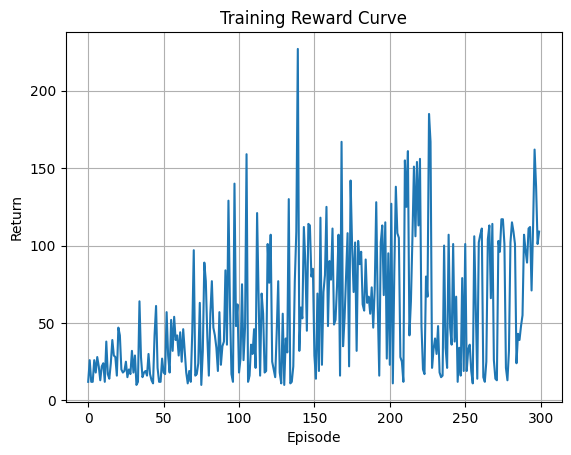

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cartpole_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/cartpole_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cartpole_videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole_videos/rl-video-episode-0.mp4


🎬 비디오 생성 완료: cartpole_videos/rl-video-episode-0.mp4


In [4]:
# ================================================
# 🎥 CartPole DQN with Visualization (Video Playback)
# DQN 기반 강화학습 예제: CartPole 문제 해결 + 비디오 녹화
# ================================================

!pip install -q gymnasium[classic-control]==0.29.1

import numpy as np
import collections
import random
import matplotlib.pyplot as plt

import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
import os


# =================================================
# 1) 강화학습 환경 생성
# - 관측: 카트 위치, 속도, 막대 각도, 각속도 → 4차원 연속 상태
# - 행동: 왼쪽 / 오른쪽 → 2개
# =================================================
env = gym.make("CartPole-v1")
obd_dim = env.observation_space.shape[0]
n_actions = env.action_space.n


# =================================================
# 2) Q-Network 정의
# - 입력: 상태 s (4차원)
# - 출력: Q(s,a) (행동 2개에 대한 Q값 벡터)
# =================================================
def create_q_net():
    model = keras.Sequential([
        layers.Input(shape=(obd_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(n_actions)  # Q(s,a0), Q(s,a1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

# 현재 Q-Network (학습 대상)
q_net = create_q_net()

# Target Q-Network (Q-net 복사본: 학습 안정화 목적)
target_q_net = create_q_net()
target_q_net.set_weights(q_net.get_weights())


# =================================================
# 3) Replay Buffer
# - 과거 경험을 저장하고 랜덤 샘플링하여 상관관계 제거(i.i.d)
# =================================================
Transition = collections.namedtuple("Transition", ["s", "a", "r", "ns", "d"])
buffer = collections.deque(maxlen=50000)


# =================================================
# 4) ε-greedy 정책
# - ε 확률로 랜덤 행동(탐색)
# - 1-ε 확률로 Q값이 가장 큰 행동(활용)
# =================================================
def select_action(state, epsilon):
    if np.random.rand() < epsilon:  # 무작위 탐색
        return np.random.randint(n_actions)

    # Q-Network 기반 행동 선택
    q = q_net(tf.convert_to_tensor(state[None, :], tf.float32))
    return int(tf.argmax(q[0]))


# =================================================
# 5) 학습 함수 (Mini-batch Gradient Update)
# Loss = (Q(s,a) - [r + γ max Q(s',·)])^2
# =================================================
@tf.function
def train_step(states, actions, rewards, next_states, dones):
    # Tensor 변환
    states_tf = tf.convert_to_tensor(states, tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states, tf.float32)
    actions_tf = tf.convert_to_tensor(actions, tf.int32)
    rewards_tf = tf.convert_to_tensor(rewards, tf.float32)
    dones_tf = tf.convert_to_tensor(dones, tf.float32)

    # 타겟 Q값 계산: Q_target = r + γ max_a' Q_target(s', a')
    next_q = target_q_net(next_states_tf)
    max_next_q = tf.reduce_max(next_q, axis=1)

    target_values = rewards_tf + 0.99 * max_next_q * (1 - dones_tf)

    # 현재 Q-Net 업데이트
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf)  # 모든 행동 Q(s,·)

        # 실제 취한 행동 a_t에 해당하는 Q(s,a_t)만 추출
        idx = tf.stack([tf.range(tf.shape(actions_tf)[0]), actions_tf], axis=1)
        chosen_q = tf.gather_nd(q_values, idx)

        # TD 오차 기반 MSE Loss 계산
        loss = tf.reduce_mean((target_values - chosen_q)**2)

    # 경사도 계산 및 업데이트
    grads = tape.gradient(loss, q_net.trainable_variables)
    q_net.optimizer.apply_gradients(zip(grads, q_net.trainable_variables))


# =================================================
# 6) 학습 루프
# =================================================
returns = []
epsilon = 1.0
state, _ = env.reset()

# 학습 전 1000개 경험 확보 (Warm-up)
while len(buffer) < 1000:
    a = env.action_space.sample()  # 랜덤 행동
    ns, r, term, trunc, _ = env.step(a)
    buffer.append(Transition(state, a, r, ns, term or trunc))
    state = ns
    if term or trunc:
        state, _ = env.reset()

print("🚀 Training Start!")

for ep in range(1, 301):
    state, _ = env.reset()
    total = 0

    for t in range(500):
        a = select_action(state, epsilon)  # 행동 선택
        ns, r, term, trunc, _ = env.step(a)

        # 경험 저장
        buffer.append(Transition(state, a, r, ns, term or trunc))
        state = ns
        total += r

        # 미니배치 학습
        batch = random.sample(buffer, 64)
        b_s = np.array([x.s for x in batch])
        b_a = np.array([x.a for x in batch], dtype=np.int32)
        b_r = np.array([x.r for x in batch], dtype=np.float32)
        b_ns = np.array([x.ns for x in batch])
        b_d = np.array([x.d for x in batch], dtype=np.float32)

        train_step(b_s, b_a, b_r, b_ns, b_d)

        if term or trunc:
            break

    epsilon = max(0.01, epsilon * 0.995)  # 탐색 감소
    returns.append(total)

    # Target 네트워크 주기적 동기화
    if ep % 10 == 0:
        target_q_net.set_weights(q_net.get_weights())
        print(f"EP {ep:03d} | Return {total:4.1f} | Epsilon {epsilon:.3f}")


# =================================================
# 7) 학습 결과 시각화
# =================================================
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Training Reward Curve")
plt.grid(True)
plt.show()


# =================================================
# 8) 학습 결과 비디오 녹화 및 재생
# =================================================
video_folder = "cartpole_videos/"
os.makedirs(video_folder, exist_ok=True)

eval_env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder,
    episode_trigger=lambda x: True  # 첫 에피소드만 녹화
)

state, _ = eval_env.reset()
done = False

# 탐욕 정책으로 실행(탐색 없이 argmax)
while not done:
    q = q_net(tf.convert_to_tensor(state[None, :], tf.float32))
    action = int(tf.argmax(q[0]))
    ns, r, term, trunc, _ = eval_env.step(action)
    done = term or trunc
    state = ns

eval_env.close()

last_video_path = os.path.join(video_folder, sorted(os.listdir(video_folder))[-1])
display(Video(last_video_path, embed=True))
print("🎬 비디오 생성 완료:", last_video_path)
